# Generating CDF generating functions 

Simon Dobson and Peter Mann<br>University of St Andrews UK

## Background

We often use generating functions to model probability distributions, for example the degree distribution of a network. In this (discrete) case, if we represent the probability of a node having degree $k$ by $p_k$, then the entire distribution is generated by the generating function

$$
G_0(x) = \sum_{k = 0}^\infty \, p_k \, x^k
$$

The generating function strings together a sequence of coefficients $\{ p_k \}_{k = 0}^\infty$ combined with a formal parameter $x$ raised to the appropriate power of $k$. It is these coefficients that are the interesting part of the construction.

This probability generating function holdsa all the information about the distribution and can be manipulated in various ways. To extract the mean degree of noes, for example, we evaluate

$$
\langle k \rangle = \sum_k k \, p_k = G_0'(1)
$$

where $G_0'(x)$ is the first derivative of $G_0(x)$ which is then executed at 1 to include all the terms. Similar operations can be performed to extract other moments and statistical features. The important point is that these operations are defined purely in terms of the generating function and so work for *any* such function, not simply one defined by explicit terms. A network with a particular degree distribution will often have a generating function that is not "spelled out" like this, but the operations still work.   

Note that the generating function is a purely formal mathematical device for representing the probability distribution, and the "derivative" is similarly a formal device for manipulating the terms in the formal series: it has nothing whatever to do with rates of change of anything.

## The problem

The cumulative density function (CDF) for a probability distribution is usually represented as $p_{k \le v}$, the probability of a node having a degree less than or equal to $v$. This is usually defined by integration of the distribution:

$$
p_{k \le v} = \sum_{k = 0}^{v} p_k
$$

where we use a discrete sum since degrees are always whole numbers. Since we have all the information we need encapsulated in the generating function, how can we generate the CDF directly from the probability generating function?

## Generating CDFs

Let us re-phrase the problem slightly. Instead of the traditional CDF, what if we are instead interested in the probability of a node having a degree *greater or equal to* some threshold? -- $p_{k \geq v}$. Intuitively is seems that this value is generated by summing the terms of $p_k$ greater than or equal to $v$, which are generated by the terms of $G_0(x)$ in powers of $x$ greater than or equal to $v$, discounting all terms in powers of $x$ less than $v$.

Having re-phrased the question in this way, it turns out that the answer is known for the general case of generating functions [[Wil94]](#generatingfunctionology).

$G_0(x)$ is a generating function built from an "ordinary" power
series, a sequence of coefficients of the form $\{ p_k \}_{k =
0}^\infty$. What function generates the sequence $\{ p_{k + 1} \}_{k =
0}^\infty$? -- in other words, dropping the first term?

$$
\sum_{k \geq 0} p_{k + 1} \, x^k = \frac{1}{x} \sum_{m \geq 1} p_m \, x^m
$$

which is

$$
G_{0, 1} (x) = \frac{G_0(x) - p_0}{x}
$$

Shifting the subscript by one changes the series by a factor
determined by the first coefficient. If we want to generate the series
from the $h$'th term then we use:

$$
G_{0, h}(x) = \frac{G_0(x) - p_0 - \cdots - p_{h - 1} \, x^{h - 1}}{x^h}
$$

So computing $G_{0, h}(1)$ gives us the probability of a node having a
degree greater than or equal to $h$.

We still need the values of $p_k$ for $k \lt h$. We can obtain these
in two ways. Firstly, they may be explicitly measurable from an
empirical or generated network. If this is the case then by definition
we have all the $p_k$, and so can compute $P_{k \geq h}$ directly as
$P_{k \geq h} = \sum_{k \geq h} p_k$.

Secondly, we can obtain $p_k$ from the $k$'th derivative of $G_0$:

$$
p_k = \frac{1}{k!} \, \left( \frac{d}{dx} \right)^k \, G_0(x) \; \Big|_{x = 0}
$$

which works for *any* degree generating function.

## Quick sanity check

Suppose we have a network with $N = 5$ and the following degree
distribution:

| $k$ | $p_k$ |
|---|---|
| 0 | 0   |
| 1 | 2/5 |
| 2 | 1/5 |
| 3 | 2/5 |

What is $P_{k \ge 2}$? Given the above we can simply read the answer
off as $p_2 + p_3 = 1/5 + 2/5 = 3/5$. The degree sequence is generated
by:

$$
G_0(x) = 0 + 2/5 x + 1/5 x^2 + 2/5 x^3
$$

Computing the CDF:

\begin{align*}
G_{0, 2}(1) &= \frac{G_0(1) - p_0 - p_1 \, x }{x^2} \\
            &= \frac{1 - 0 - 2/5}{1} \\
            &= 3/5
\end{align*}

## Larger sanity check

For a better sanity check, we compare the empirical calculation of $p_{k \geq v}$ for a network against the value generated by the CDF generating function. 

In [288]:
import math
import cmath
import functools
import numpy
import networkx
import scipy
import mpmath
import epydemic

import matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'png'
matplotlib.rcParams['figure.dpi'] = 300
import matplotlib.pyplot as plt
import seaborn
matplotlib.style.use('seaborn')
seaborn.set_context('notebook', font_scale=0.75)

We will start with an ER network of $N = 10^4$ nodes and $\langle k \rangle = 8$.

In [49]:
N = int(1e4)
kmean = 8

We create a network with this topology.

In [50]:
g = networkx.fast_gnp_random_graph(N, kmean / N)

Given a network, we can compute the number of nodes of each degree simply by counting.

In [171]:
def nk_g(g):
    degrees = dict()
    for (_, k) in g.degree:
        if k in degrees:
            degrees[k] += 1
        else:
            degrees[k] = 1
    
    def nk(k):
        if k in degrees:
            return degrees[k]
        else:
            return 0
        
    return nk

From this we can define a function that gives the empirical value of $p_k$ for any network.

In [174]:
def pk_g(g):
    nk = nk_g(g)
    
    def pk(k):
        return nk(k) / g.order()
    
    return pk

For an ER network, the probability of randomly choosing a node with a given degree is

$$
p_k = \frac{\langle k \rangle^k e^{-\langle k \rangle}}{k!}
$$

which we can code directly.

In [251]:
def pk_ER(kmean):
    '''Return a function that computes p_k for a given k on an ER network.'''
    def pk(k):
        return (math.pow(kmean, k) * math.exp(-kmean)) / math.factorial(k)
    return pk

This function, when called with the parameters of the ER network, returns a function for $p_k$.

We can check these functions by plotting the theoretical and empirical probabilities on the same axes.

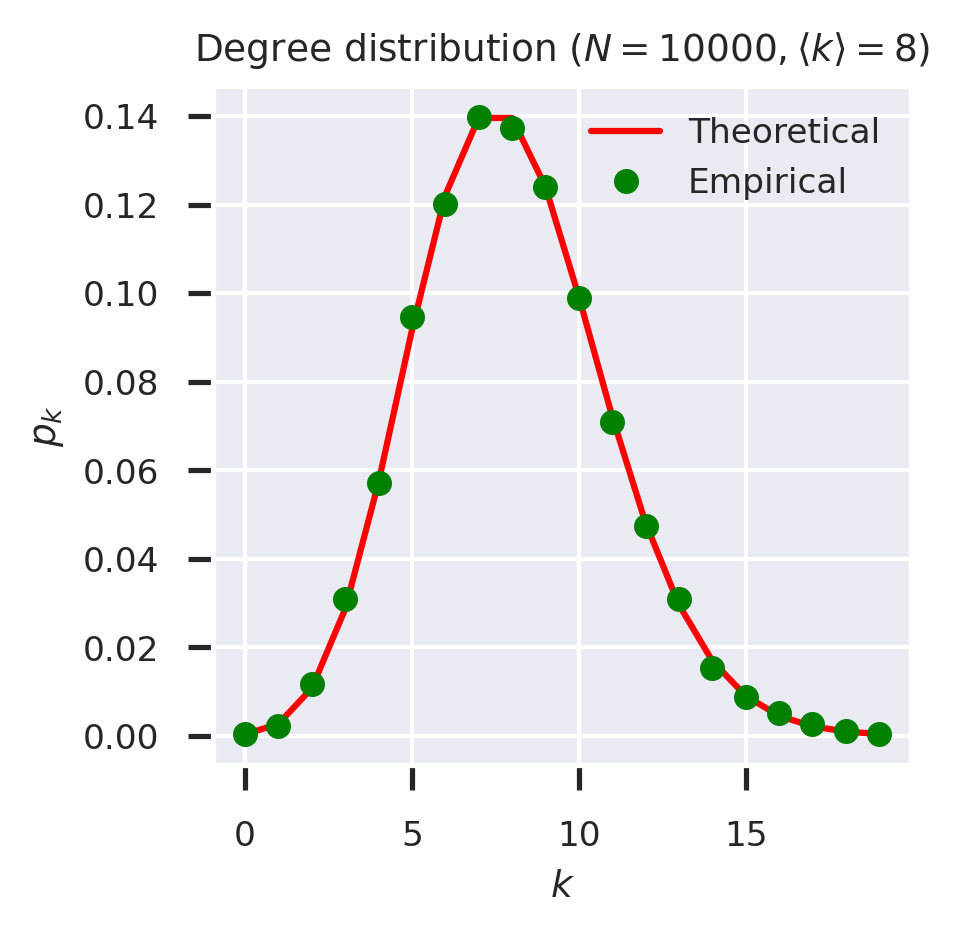

In [252]:
fig = plt.figure(figsize=(3,3))

ks = list(range(20))
theoretical = list(map(pk_ER(kmean), ks))
ds = nk(g)
empirical = [(ds[k] / N if k in ds else 0) for k in ks]

plt.plot(ks, theoretical, 'r-', label='Theoretical')
plt.plot(ks, empirical, 'go', label='Empirical')

plt.xlabel('$k$')
plt.ylabel('$p_k$')
plt.legend(loc='upper right')
plt.title(f'Degree distribution ($N = {N}, \\langle k \\rangle = {kmean}$)')

plt.show()

From the empirical computation of $p_k$ it is easy to derive $p_{k \geq v}$ by summing -up the probabilities. Again, we define a function that, given a function that computes $p_k$, returns a function that computes $p_{k \geq v}$ 

In [156]:
def cdf_g(g):
    '''Return the CDF of the given network.'''
    
    def cdf(v):
        ds = nk(g)
        gte = 0
        for k in ds:
            if k >= v:
                gte += ds[k]
        return gte / g.order()
    
    return cdf

In [157]:
cdf_g(g)(10)

0.2815

Let us now turn to the generating function approach. The degree distribution for an ER network is generated [[NSW01]](#NSW01) by

$$
G_0(x) = e^{\langle k \rangle (x - 1)}
$$

In [280]:
def G0_ER(kmean):
    '''Return the degree generating function for an ER network with mean degree kmean.'''
    
    def G0(x):
        return cmath.exp(kmean * (x - 1))   # note use of complex exponentiation
    
    return G0

Given a degree generating function we can extract $p_k$ by taking derivatives. If we know the generating function we can sometimes perform this symbolically, but a numerical solution would work for *any* generating function, notably for those built piecemeal from arbitrary distributions. The naive approach suffers from numerical instability, but [[NSW01]](#NSW01) suggests a solution: differentiate the function using the Cauchy contour integral and the residue theorem:

$$
f^{(n)}(a) = \frac{n!}{2\pi}\int_0^{2\pi} f(re^{i\theta} + a)r^{-n}e^{-i\theta n }d\theta
$$

where $r$ is the radius of a small region around the point of interest.

In [293]:
def differentiate(f, a, n=1, r=1.0, dx=1e-6):
    '''Compute the n'th derivative of f at a using a Cauchy contour integral of radius r.'''
    
    # make sure the function vectorises
    if not isinstance(f, numpy.vectorize):
        f = numpy.vectorize(f)
        
    z = r * numpy.exp(2j * numpy.pi * numpy.arange(0, 1, dx))
    return math.factorial(n) * numpy.mean(f(a + z) / z**n)

We can then use this to extract the individual degree probailities by differentiating the degree denerating function the appropriate number of times and evaluating the derivative at zero.

In [289]:
def pk_gen(G0):
    '''Return p_k from the degree generating function G0.'''
    
    @functools.lru_cache()
    def pk(k):
        return differentiate(G0, 0, dx=1e-2, n=k).real / math.factorial(k)
    
    return pk

(Since degrees are always real, and indeed integer, it's safe to extract only the real part of the computed derivative.) We can now see whether the degrees from the degree distribution align with those extracted from the generating function. 

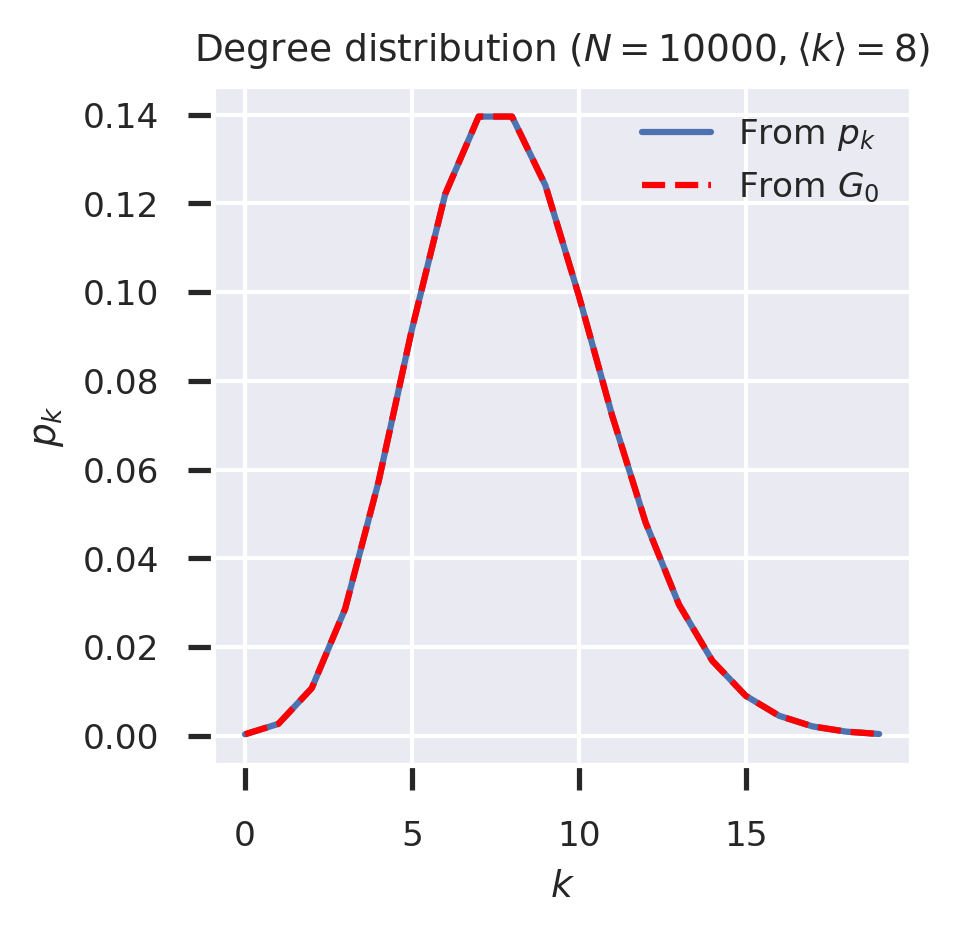

In [290]:
fig = plt.figure(figsize=(3, 3))

ks = range(20)
p = pk_ER(kmean)
G0 = G0_ER(kmean)
from_pk = [p(k) for k in ks]
from_G0 = [differentiate(G0, a=0., n=k, r=1., dx=1e-2).real / math.factorial(k) for k in ks]

plt.plot(ks, from_pk, label='From $p_k$')
plt.plot(ks, from_G0,color='r', label='From $G_0$', linestyle='--')
plt.legend()
plt.xlabel('$k$')
plt.ylabel('$p_k$')
plt.legend(loc='upper right')
plt.title(f'Degree distribution ($N = {N}, \\langle k \\rangle = {kmean}$)')
plt.show()

The CDF generating function can then be synthesised from the degree distribution generating function.

In [274]:
def cdf_gen(G0, v):
    '''Return the CDF at v from the degree generating function G0.'''
    
    @functools.lru_cache()
    def G0_v(x):
        pk = pk_gen(G0)
        s = 1 - sum([pk(k) for k in range(v)])
        return s / math.pow(x, v)
    
    return G0_v

In [270]:
cdf_gen(G0_ER(kmean), 10)(1)

0.28337574127298937

To check the workings of the CDF generating function we can again plot the empirical and theoertical results side by side. 

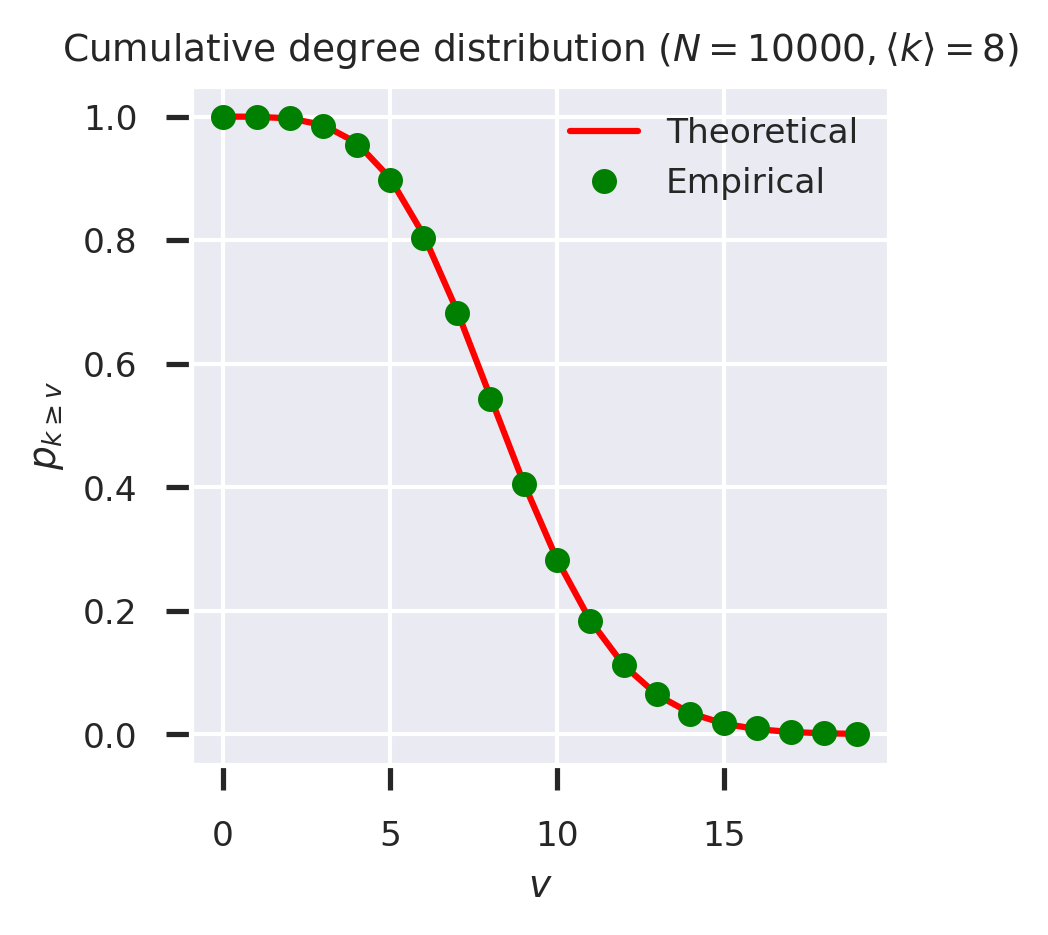

In [291]:
fig = plt.figure(figsize=(3,3))

ks = list(range(20))
theoretical = list(map(lambda k: cdf_gen(G0_ER(kmean), k)(1), ks))
empirical = list(map(cdf_g(g), ks))

plt.plot(ks, theoretical, 'r-', label='Theoretical')
plt.plot(ks, empirical, 'go', label='Empirical')

plt.xlabel('$v$')
plt.ylabel('$p_{k \geq v}$')
plt.ylim([-0.05, 1.05])
plt.legend(loc='upper right')
plt.title(f'Cumulative degree distribution ($N = {N}, \\langle k \\rangle = {kmean}$)')

plt.show()

Our claim was that this technique can work with *any* generating function. To test this, let's create a powerlaw-with-cutoff degree distribution and apply the same CDF process to its generating function, comparing with the empirical solution.

In [179]:
N_PLC = int(1e5)
tau = 3
kappa = 50

In [180]:
params = dict()
params[epydemic.PLCNetwork.N] = N_PLC
params[epydemic.PLCNetwork.EXPONENT] = tau
params[epydemic.PLCNetwork.CUTOFF] = kappa

g_plc = epydemic.PLCNetwork(params).generate()

The degree distribution is generated [[NSW01]](#NSW01) by

$$
G_0(x) = \frac{Li_\tau(x e^{-1 / \kappa})}{Li_\tau(e^{-1 / \kappa})}
$$

which again can be coded directly.

In [286]:
def G0_PLC(tau, kappa):
    '''Return the degree generating function for a powerlaw-with-cutoff network with exponent tau and cutoff kappa.'''
    
    @functools.lru_cache()
    def G0(x):
        return mpmath.polylog(tau, x * math.exp(-1 / kappa)) / mpmath.polylog(tau, math.exp(-1 / kappa))
    
    return G0

Plotting theoretical and empirical results again, this time on a log-linear scale, gives:

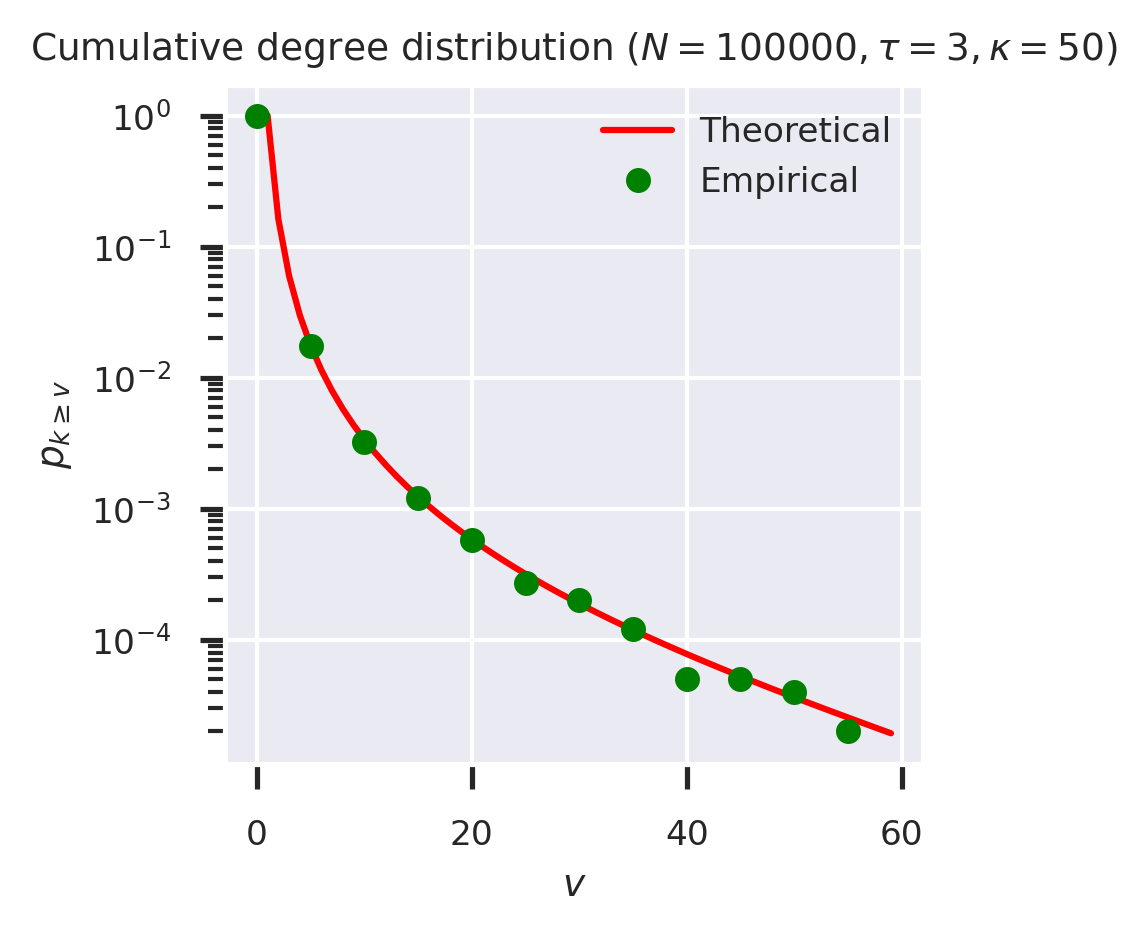

In [292]:
fig = plt.figure(figsize=(3,3))

ks = list(range(60))
theoretical = list(map(lambda k: cdf_gen(G0_PLC(tau, kappa), k)(1), ks))
empirical = list(map(cdf_g(g_plc), ks))

plt.plot(ks, theoretical, 'r-', label='Theoretical')
plt.plot(ks[::5], empirical[::5], 'go', label='Empirical')

plt.xlabel('$v$')
plt.ylabel('$p_{k \geq v}$')
plt.yscale('log')
plt.legend(loc='upper right')
plt.title(f'Cumulative degree distribution ($N = {N_PLC}, \\tau = {tau}, \\kappa = {kappa}$)')

plt.show()

## References

<a name="NSW01">[NSW01]</a> M.E.J. Newman, Steven Strogatz, and Duncan Watts. Random graphs with arbitrary degree distributions and their applications. Physical Review E **64**. 2001.

<a name="generatingfunctionology">[Wil94]</a> Herbert Wilf. Generatingfunctionology. Academic Press. 1994.